In [48]:
import sympy as sp
from sympy import sin, cos, Matrix, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

![](LowerLimb.png)

In [30]:
# Define the symbolic variables
q1, q2, omega1, omega2 = sp.symbols(r'q_1 q_2 \omega_1 \omega_2')
dot_omega1, dot_omega2 = sp.symbols(r'\dot{\omega}_1 \dot{\omega}_2')
l1, l2, L1, L2 = sp.symbols(r'l_1 l_2 L_1 L_2')
m1, m2, m3 = sp.symbols(r'm_1 m_2 m_3')
J1, J2 = sp.symbols(r'J_1 J_2')
T1_sym, T2_sym = sp.symbols(r'T_1 T_2')
b1, b2 = sp.symbols(r'b_1 b_2')
t, g = sp.symbols('t g')

q1 = sp.Function('q_1')(t)
q2 = sp.Function('q_2')(t)

w1 = q1.diff(t)
w2 = q2.diff(t)

dot_w1 = w1.diff(t)
dot_w2 = w2.diff(t)

In [31]:
# Position of the center of mass for tigh, shank and foot
r1 = Matrix([l1 * sin(q1),
             -l1 * cos(q1)])

r2 = Matrix([L1 * sin(q1) + l2 * sin(q2),
             -L1 * cos(q1) - l2 * cos(q2)])

r3 = Matrix([L1 * sin(q1) + L2 * sin(q2),
            -L1 * cos(q1) - L2 * cos(q2)])

In [32]:
# Velocity of the center of mass for tigh, shank and foot
v1 = r1.diff(t)
v2 = r2.diff(t)
v3 = r3.diff(t)

In [33]:
# Kinetic energy of the system
T1 = 0.5 * m1 * v1.dot(v1) + 0.5 * J1 * q1.diff(t)**2
T2 = 0.5 * m2 * v2.dot(v2) + 0.5 * J2 * q2.diff(t)**2
T3 = 0.5 * m3 * v3.dot(v3) + 0.5 * m3 * (r3[0]**2 + r3[1]**2) * q2.diff(t)**2

T_total = T1 + T2 + T3

In [34]:
# Potential energy of the system
h1 = -l1 * cos(q1)
h2 = -L1 * cos(q1) - l2 * cos(q2)
h3 = -L1 * cos(q1) - L2 * cos(q2)

V1 = m1 * g * h1
V2 = m2 * g * h2
V3 = m3 * g * h3

V_total = V1 + V2 + V3

**Lagrange Function**

$$L = T - V$$

$$
L = T_1 + T_2 + T_3 - V_1 - V_2 - V_3
$$


In [35]:
L = T_total - V_total

**Approach:**
$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_i} \right) - \frac{\partial L}{\partial q_i} = Q_i$$

$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_1} \right) - \frac{\partial L}{\partial q_1} = T_1 - b_1 \dot{q}_1 - b_2 (\dot{q}_1 - \dot{q}_2)$$

$$\frac{\partial}{\partial t} \left(\frac{\partial L}{\partial \dot{q}_2} \right) - \frac{\partial L}{\partial q_2} = T_2 - b_2 (\dot{q}_2 - \dot{q}_1)$$

- $q_i$: Set of the generalized coordinates
- $Q_i$: Set of external (non-conservative) forces applied to the system (2 DOF are associated with the hip and knee joint)
- $T_n$: Torque acting at each joint
- $b_n$: viscous damping coefficient

In [37]:
dL_d_dot_q1 = L.diff(q1.diff(t))
dL_d_dot_q2 = L.diff(q2.diff(t))

dL_d_dot_q1_dt = dL_d_dot_q1.diff(t)
dL_d_dot_q2_dt = dL_d_dot_q2.diff(t)

dL_dq1 = L.diff(q1)
dL_dq2 = L.diff(q2)

Q1 = T1_sym - b1 * q1.diff(t) - b2 * (q1.diff(t) - q2.diff(t))
Q2 = T2_sym - b2 * (q2.diff(t) - q1.diff(t))

In [39]:
# Substitute the values of the parameters
subsDict = {q1.diff(t): omega1,
            q2.diff(t): omega2,
            q1.diff(t, 2): dot_omega1,
            q2.diff(t, 2): dot_omega2,}

dL_d_dot_q1_dt.subs(subsDict).simplify()
dL_d_dot_q2_dt.subs(subsDict).simplify()

dL_dq1.subs(subsDict).simplify()
dL_dq2.subs(subsDict).simplify()

Q1.subs(subsDict).simplify()
Q2.subs(subsDict).simplify()

T_2 + b_2*(\omega_1 - \omega_2)

In [40]:
eq1 = dL_d_dot_q1_dt - dL_dq1 - Q1
eq2 = dL_d_dot_q2_dt - dL_dq2 - Q2

eq1 = eq1.subs(subsDict).simplify()
eq2 = eq2.subs(subsDict).simplify()

In [42]:
# Solve for omega1_dot and omega2_dot
sol = sp.solve([eq1, eq2], (dot_omega1, dot_omega2))

In [43]:
dot_omega1_sol = sol[dot_omega1].simplify()

In [44]:
dot_omega2_sol = sol[dot_omega2].simplify()

In [45]:
# Define the parameters
m_body = 100 # Body mass [kg]
m1_val = 9.73; m2_val = 5.07; m3_val = 0.44 # Masses [kg]

L1_val = 0.41; l1_val = L1_val / 2 # Lengths thigh [m]
L2_val = 0.415; l2_val = L2_val / 2 # Lengths shank [m]

r_G1 = 0.132; r_G2 = 0.125 # Radius of gyration [m]
J1_val = m1_val * r_G1**2; J2_val = m2_val * r_G2**2 # Moments of inertia [kg m^2]

b1_val = 0.1; b2_val = 0.1 # Damping coefficients [N m s/rad]

g_val = 9.81 # Gravity [m/s^2]

# Subustitute dictionary
parameterDict = {m1: m1_val, m2: m2_val, m3: m3_val,
                L1: L1_val, l1: l1_val, L2: L2_val, l2: l2_val,
                J1: J1_val, J2: J2_val,
                b1: b1_val, b2: b2_val,
                g: g_val}

# Substitute the values of the parameters
dot_omega1_sol = dot_omega1_sol.subs(parameterDict)
dot_omega2_sol = dot_omega2_sol.subs(parameterDict)

In [47]:
dot_omega1_func = sp.lambdify((q1, q2, omega1, omega2, T1_sym, T2_sym), dot_omega1_sol, 'numpy')
dot_omega2_func = sp.lambdify((q1, q2, omega1, omega2, T1_sym, T2_sym), dot_omega2_sol, 'numpy')

In [26]:
# Read gait data
filename = 'gait_data.xls'
gait_data = pd.read_excel(filename, engine='xlrd')

# Extract gait data
gait_step = np.array(gait_data["gait_%"]) / 100

GRFz = np.array(gait_data["GRFz[%BW]"]) * m_body * g_val / 100
GRFx = gait_data["GRFx[%BW]"] * m_body * g_val / 100

MX_H = np.array(gait_data["MX_H[Nm/kg]"]) * m_body
MX_K = np.array(gait_data["MX_K[Nm/kg]"]) * m_body
MX_F = np.array(gait_data["MX_F[Nm/kg]"]) * m_body

q1_gait = np.deg2rad(np.array(gait_data["Flex_Ext_H[deg]"]))
q2_gait = np.deg2rad(np.array(gait_data["Flex_Ext_K[deg]"]))

In [49]:
# Precompute interpolating functions for M1 and M2
MX_H_interp = interp1d(gait_step, MX_H, kind='cubic', fill_value='extrapolate')
MX_K_interp = interp1d(gait_step, MX_K, kind='cubic', fill_value='extrapolate')

In [51]:
# Time step
dt = 0.01
t_start = 0
t_end = 1
t_eval = np.arange(t_start, t_end, dt)

# initial conditions
q1_0 = q1_gait[0] # initial angle of the thigh
q2_0 = q2_gait[0] # initial angle of the shank

omega1_0 = 0
omega2_0 = 0

y0 = [omega1_0, omega2_0, q1_0, q2_0]

In [52]:
# Define the function to solve
def leg_model(t, y):
    omega1, omega2, q1, q2 = y

    T1 = MX_H_interp(t)
    T2 = MX_K_interp(t)

    domega1 = dot_omega1_func(q1, q2, omega1, omega2, T1, T2)
    domega2 = dot_omega2_func(q1, q2, omega1, omega2, T1, T2)

    dq1 = omega1
    dq2 = omega2

    return [domega1, domega2, dq1, dq2]

In [53]:
# Solve the ODE
sol = solve_ivp(leg_model, [t_start, t_end], y0, t_eval=t_eval)

In [54]:
t_sol = sol.t

omega1_sol = sol.y[0]
omega2_sol = sol.y[1]

q1_sol = sol.y[2]
q2_sol = sol.y[3]

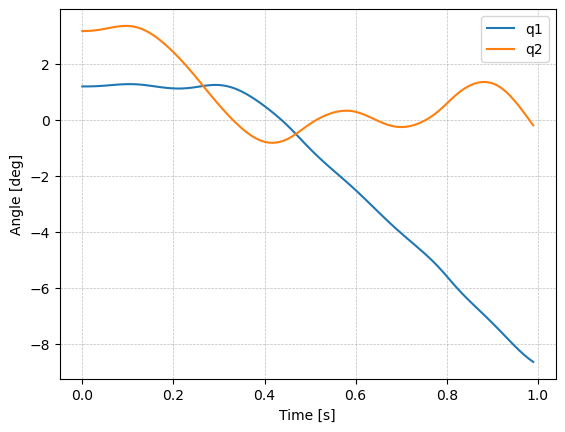

In [58]:
# plot the angles
plt.figure()
plt.plot(t_sol, q1_sol, label='q1')
plt.plot(t_sol, q2_sol, label='q2')
plt.xlabel('Time [s]')
plt.ylabel('Angle [deg]')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

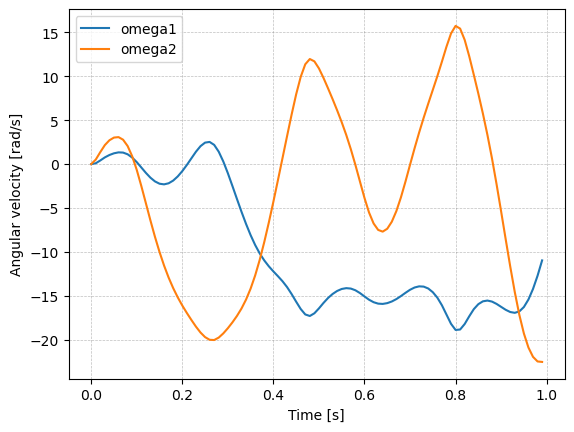

In [56]:
# plot the angular velocities
plt.figure()
plt.plot(t_sol, omega1_sol, label='omega1')
plt.plot(t_sol, omega2_sol, label='omega2')
plt.xlabel('Time [s]')
plt.ylabel('Angular velocity [rad/s]')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()

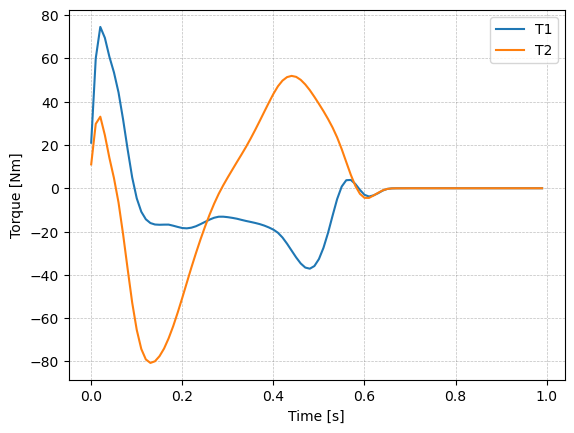

In [57]:
# plot the torques
plt.figure()
plt.plot(t_sol, MX_H_interp(t_sol), label='T1')
plt.plot(t_sol, MX_K_interp(t_sol), label='T2')
plt.xlabel('Time [s]')
plt.ylabel('Torque [Nm]')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()